# Manufacturing transistors

Silicon Valley Corporation (Silvco) manufactures transistors.  An
important aspect of the manufacturing process is the melting of the
element germanium in a furnace. Unfortunately, the melting process
yields germanium of highly variable quality. The results of the
process can be classified into five grades: "defective", "grade 1",
"grade 2", "grade 3", and "grade 4".  Two methods can be used to do
the melting. Method 1 costs \\$50 per transistor, and method 2 costs \\$70
per transistor. The qualities of germanium produced by the melting are
shown in the following table (as percentage yields):<br>

|         |method1|method2|
|---------|-------|-------|
|defective|30     |20     |
|grade1   |30     |20     |
|grade2   |20     |25     |
|grade3   |15     |20     |
|grade4   |5      |15     |

Silvco can refire melted germanium in an attempt to improve its
quality. It costs \$25 to refire the melted germanium for one
transistor. The results of the refiring process are shown in the table
below. For example, if grade 3 germanium is refired, half of the
resulting germanium will still be grade 3 while the other half will be
grade 4.

|         |defective|grade1|grade2|grade3|grade4|
|---------|---------|------|------|------|------|
|defective|30       |25    |15    |20    |10    |
|grade1   |         |30    |30    |20    |20    |
|grade2   |         |      |40    |30    |30    |
|grade3   |         |      |      |50    |50    |

Silvco has sufficient furnace capacity to melt or refire germanium for
at most 20,000 transistors per month. Silvco's monthly demands are for
1000 grade-4 transistors, 2000 grade-3 transistors, 3000 grade-2
transistors, and 3000 grade-1 transistors.

### Assuming that just one stage of refiring is allowed, model the melting/refiring process and determine the minimum cost of germanium processing required to meet the demands.  Ensure that you round your results to an integer value.

In [1]:
# Load the gams extension
%load_ext gams_magic

import pandas as pd

# Enable plots to be shown in notebook
%matplotlib inline
from matplotlib import pyplot as plt

__The GAMS Model:__

In [2]:
%%gams

Set
    grades 'grades' / defective, grade1, grade2, grade3, grade4 /,
    methods 'methods' / method1, method2 /;
  
alias (grades,k);
  
Table qualities(grades,methods) 'qualities of germanium produced by the melting'
                method1 method2
    defective      30       20
    grade1         30       20
    grade2         20       25
    grade3         15       20
    grade4         5        15;

Parameter costs(methods) 'costs of each method'    / method1  50,
                                                     method2  70 /;
                                               
Table refiring(grades,grades) 'results of the refiring process'
                defective grade1 grade2 grade3 grade4
     defective     30       25     15     20     10
     grade1         0       30     30     20     20
     grade2         0       0      40     30     30
     grade3         0       0      0      50     50
     grade4         0       0      0      0      0;

Parameter ref_price 'price for refire the melted germanium for one transistor' /25/;
    
Parameter transistors_max 'transistor furnace capacity' /20000/;

Parameter demand(grades) 'monthly demands'    / defective     0,
                                                grade1     3000,
                                                grade2     3000,
                                                grade3     2000,
                                                grade4     1000 /;

Variables
    z                           'cost'
    numberMelted(methods)       'melting processed by method'
    numberRefired(grades)       'refired for each grade'
    numberAfterRefiring(grades) 'results after refering process'
    numberAfterMelting(grades)  'results just after melting'; 

Positive Variable numberMelted, numberRefired;

Equation
    obj 'calculate the total cost'
    eq_numberAfterMelting(grades)
    eq_numberRefired(grades)
    eq_numberAfterRefiring(grades)
    eq_demand(grades)
    ;

    obj..sum(grades,numberRefired(grades)*ref_price) + sum(methods,numberMelted(methods)*costs(methods)) =e= z;
    eq_numberAfterMelting(grades).. numberAfterMelting(grades) =e= sum(methods, qualities(grades,methods)*numberMelted(methods))/100;
    eq_numberRefired(grades).. numberRefired(grades) =l= numberAfterMelting(grades);
    eq_numberAfterRefiring(grades).. numberAfterRefiring(grades) =e= numberAfterMelting(grades) - numberRefired(grades) + sum(k,numberRefired(k)*refiring(k,grades))/100;    
    eq_demand(grades).. numberAfterRefiring(grades) =g= demand(grades);

model prob /all/;
Options LP  = Cplex;
Solve prob using LP minimizing z;
display numberMelted.l, numberAfterMelting.l, numberRefired.l, numberAfterRefiring.l, z.l;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),641725.3521,21,18,LP,CPLEX,0.015


__Pull the variable values from GAMS and create a bar chart for the results:__

,methods,level,marginal,lower,upper,scale
0,method1,10563.0,0.00000,0.0,inf,1.0
1,method2,0.0,16.28081,0.0,inf,1.0


,grades,level,marginal,lower,upper,scale
0,defective,3169.0,0.0,-inf,inf,1.0
1,grade1,3169.0,0.0,-inf,inf,1.0
2,grade2,2113.0,0.0,-inf,inf,1.0
3,grade3,1585.0,0.0,-inf,inf,1.0
4,grade4,528.0,0.0,-inf,inf,1.0


,grades,level,marginal,lower,upper,scale
0,defective,3169.0,0.000000,0.0,inf,1.0
1,grade1,1373.0,0.000000,0.0,inf,1.0
2,grade2,0.0,129.841549,0.0,inf,1.0
3,grade3,0.0,25.000000,0.0,inf,1.0
4,grade4,0.0,25.000000,0.0,inf,1.0


,grades,level,marginal,lower,upper,scale
0,defective,951.0,0.0,-inf,inf,1.0
1,grade1,3000.0,0.0,-inf,inf,1.0
2,grade2,3000.0,0.0,-inf,inf,1.0
3,grade3,2493.0,0.0,-inf,inf,1.0
4,grade4,1120.0,0.0,-inf,inf,1.0


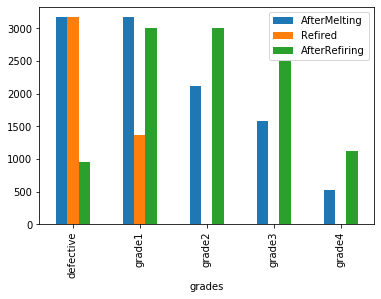

In [3]:
# Pull the values of x from GAMS to Python as a pandas dataframe
%gams_pull -d numberMelted numberAfterMelting numberRefired numberAfterRefiring

numberMelted['level'] = numberMelted['level'].round(0)
numberAfterMelting['level'] = numberAfterMelting['level'].round(0)
numberRefired['level'] = numberRefired['level'].round(0)
numberAfterRefiring['level'] = numberAfterRefiring['level'].round(0)
display(numberMelted,numberAfterMelting,numberRefired,numberAfterRefiring)

data = {'grades':numberAfterMelting['grades'],'AfterMelting':numberAfterMelting['level'],'Refired':numberRefired['level'],'AfterRefiring':numberAfterRefiring['level']}
results = pd.DataFrame(data)
results.set_index('grades',drop=True,inplace=True)
results.plot(kind='bar');
